<a href="https://colab.research.google.com/github/hiydavid/tfdev_learning/blob/main/ZTM/exercises/tfdev_exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 04: Transfer Learning Feature Extraction

---

## 1) Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

In [1]:
# download data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-03-22 06:04:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  45.6MB/s    in 3.5s    

2022-03-22 06:04:36 (45.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# create dataloader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255) 

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

print("Testing images:")
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [3]:
# create tensorboard callback
from datetime import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log file to {log_dir}")
    return tensorboard_callback

In [9]:
# import
import tensorflow_hub as hub
import tensorflow as tf

# get urls
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [5]:
# make a create_model function
def create_model(model_url, num_classes=10):
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False, # freeze the pretrained weights
        input_shape=IMAGE_SHAPE + (3,)
    )

    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(
            num_classes, 
            activation="softmax",
            name="output_layer"
        )
    ])

    return model

In [10]:
# create and testing resnet
mobilenet_model = create_model(
    mobilenet_url,
    num_classes=train_data_10_percent.num_classes
)

In [11]:
# get summary
mobilenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
# compile & fit pretrained model
mobilenet_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

hist_mobilenet = mobilenet_model.fit(
    train_data_10_percent, 
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(
        dir_name="tensorflow_hub",
        experiment_name="resnet50v2"
    )]
)

Saving TensorBoard log file to tensorflow_hub/resnet50v2/20220322-060651
Epoch 1/5
24/24 [==============================] - 54s 2s/step - loss: 1.9024 - accuracy: 0.3627 - val_loss: 1.2511 - val_accuracy: 0.6156
Epoch 2/5
24/24 [==============================] - 18s 767ms/step - loss: 1.0159 - accuracy: 0.7133 - val_loss: 0.8781 - val_accuracy: 0.7404
Epoch 3/5
24/24 [==============================] - 18s 791ms/step - loss: 0.7196 - accuracy: 0.8067 - val_loss: 0.7289 - val_accuracy: 0.7808
Epoch 4/5
24/24 [==============================] - 18s 772ms/step - loss: 0.5773 - accuracy: 0.8507 - val_loss: 0.6844 - val_accuracy: 0.7836
Epoch 5/5
24/24 [==============================] - 20s 841ms/step - loss: 0.4818 - accuracy: 0.8827 - val_loss: 0.6465 - val_accuracy: 0.8012


In [13]:
# create a function to plot loss curve
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

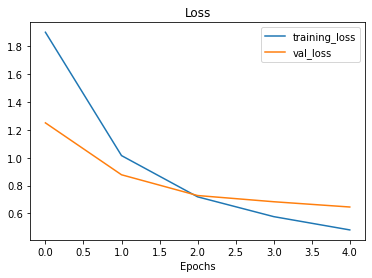

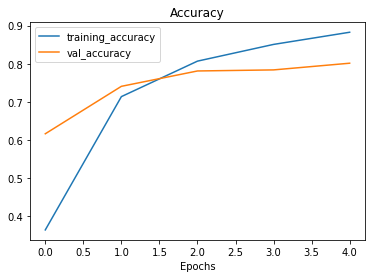

In [14]:
# plot
plot_loss_curves(hist_mobilenet)

## 2) Name 3 different image classification models on TensorFlow Hub that we haven't used.

In [17]:
# 1) NASNet
# 2) Inception v3
# 3) EfficientNet v2

## 3) Build a model to classify images of two different things you've taken photos of.
* You can use any feature extraction layer from TensorFlow Hub you like for this.
* You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.


In [18]:
# skip

## 4) What is the current best performing model on ImageNet?

In [ ]:
# skip